<a href="https://colab.research.google.com/github/Ketan1218/Applied_Data_Science_Capstone/blob/main/MTE_FITNESS_PROJECT_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 1: Obtain and Review Raw Data**

While having a conversation with an old running friend about our training habits and accomplishments, I had an epiphany that I could analyze my training in detail. I have been using Runkeeper, a well-known GPS fitness tracker, for years and decided to examine my running data. I have been using the Runkeeper app since 2012 and one of its best features is its ability to export data.

Anyone with a smartphone can download the app and analyze their data like we will in this notebook. After logging a run, the first step is to export the data from Runkeeper, which I have already done. Then, the data can be imported and explored to identify potential issues. Data cleaning strategies can be developed to address these issues before analyzing and visualizing the clean time-series data.

I exported seven years of training data from 2012 to 2018. The data is in a CSV file where each row represents a single training activity. Let’s load and examine it.

In [21]:
          # Task 1: 
          # Import pandas
          import pandas as pd

          # Define file containing dataset
          runkeeper_file = '/cardioActivities.csv'

          # Create DataFrame with parse_dates and index_col parameters 
          df_activities = pd.read_csv(runkeeper_file, parse_dates=['Date'], index_col='Date')

          # First look at exported data: select sample of 3 random rows 
          display(df_activities.sample(3))

          # Print DataFrame summary
          df_activities.info()

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2015-08-09 16:29:48,632b4c1e-96ce-4e45-9d8e-945b64c8d912,Running,NaN,18.58,1:48:49,5:51,10.25,1278.999999,285,138.0,NaN,TomTom MySports Watch,2015-08-09-162948.gpx
2015-07-12 18:14:14,8e08fa81-ec96-4811-8ac2-db1250c9cee1,Running,NaN,19.04,1:51:58,5:53,10.20,1316.000000,295,133.0,NaN,NaN,2015-07-12-181414.gpx
2013-07-21 07:57:30,924ee968-8f2c-47d9-a005-dbc732966fab,Running,NaN,11.87,1:00:37,5:07,11.74,845.000000,64,NaN,NaN,NaN,2013-07-21-075730.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Id               508 non-null    object 
 1   Type                      508 non-null    object 
 2   Route Name                1 non-null      object 
 3   Distance (km)             508 non-null    float64
 4   Duration                  508 non-null    object 
 5   Average Pace              508 non-null    object 
 6   Average Speed (km/h)      508 non-null    float64
 7   Calories Burned           508 non-null    float64
 8   Climb (m)                 508 non-null    int64  
 9   Average Heart Rate (bpm)  294 non-null    float64
 10  Friend's Tagged           0 non-null      float64
 11  Notes                     231 non-null    object 
 12  GPX File                  504 non-null    object 
dtypes: float64(5), int64(1), obj

**Task 2: Data-preprocessing**. 

Fortunately, the column names provided by Runkeeper are self-explanatory and do not require renaming. However, using the info() method, we can see that there are missing values. 

The reasons for these missing values vary. For example, some heart rate information is missing because I did not always use a heart rate monitor. The Notes column is optional and was sometimes left blank. The Route Name column was only used once and the Friend’s Tagged column was never used. To avoid misleading results later on, we will fill in the missing values in the heart rate column. 

Our initial data preprocessing steps will include removing columns that are not relevant to our analysis, changing the “Other” activity type to “Unicycling” as that was always the activity recorded as “Other,” and counting the number of missing values.

In [3]:
          # TASK 2: Data preprocessing

          # Define list of columns to be deleted
          drop_cols = ['Friend\'s Tagged','Route Name','GPX File','Activity Id','Calories Burned', 'Notes']

          # Delete unnecessary columns
          df_activities.drop(drop_cols, axis=1, inplace=True)

          # Count types of training activities
          display(df_activities.Type.value_counts())

          # Rename 'Other' type to 'Unicycling'
          df_activities['Type'] = df_activities['Type'].str.replace('Other', 'Unicycling', regex=False)

          # Count missing values for each column
          df_activities.isnull().sum(axis=0)

Running    459
Cycling     29
Walking     18
Other        2
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Climb (m)                     0
Average Heart Rate (bpm)    214
dtype: int64

**Task 3: Dealing with missing values**

From the previous output, we can see that there are 214 missing values for my average heart rate. 

We can't go back and get those values, but we can fill them in with an average value. This is called mean imputation. When filling in missing values with the mean, we need to remember that the average heart rate is different for different activities like walking or running. So, we'll separate the data by activity type and calculate the average heart rate for each activity. Then we'll use those averages to fill in the missing values.

In [4]:
          # TASK 3: Dealing with missing values

          # Calculate sample means for heart rate for each training activity type 
          avg_hr_run = df_activities[df_activities['Type'] == 'Running']['Average Heart Rate (bpm)'].mean()
          avg_hr_cycle = df_activities[df_activities['Type'] == 'Cycling']['Average Heart Rate (bpm)'].mean()

          # Split whole DataFrame into several, specific for different activities
          df_run = df_activities[df_activities['Type'] == 'Running'].copy()
          df_walk = df_activities[df_activities['Type'] == 'Walking'].copy()
          df_cycle = df_activities[df_activities['Type'] == 'Cycling'].copy()

          # Filling missing values with counted means  
          df_walk['Average Heart Rate (bpm)'].fillna(110, inplace=True)
          df_run['Average Heart Rate (bpm)'].fillna(int(avg_hr_run), inplace=True)
          # CODE FOR TASK 3 
          df_cycle['Average Heart Rate (bpm)'].fillna(int(avg_hr_cycle), inplace=True)

          # Count missing values for each column in running data
          df_run.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

**Task 4: Plot Running Data**

It's time to make our first graph! Earlier, we found out that most of the activities in my data were running (459 to be exact). There were only a few instances of cycling (29), walking (18), and unicycling (2). So for now, let's just focus on making a graph for the different running measurements. 

A good first graph would be one with four smaller graphs inside it, one for each running measurement. Each smaller graph will have its own y-axis, which will be explained in the legend. The x-axis, which shows the date, will be the same for all the smaller graphs.

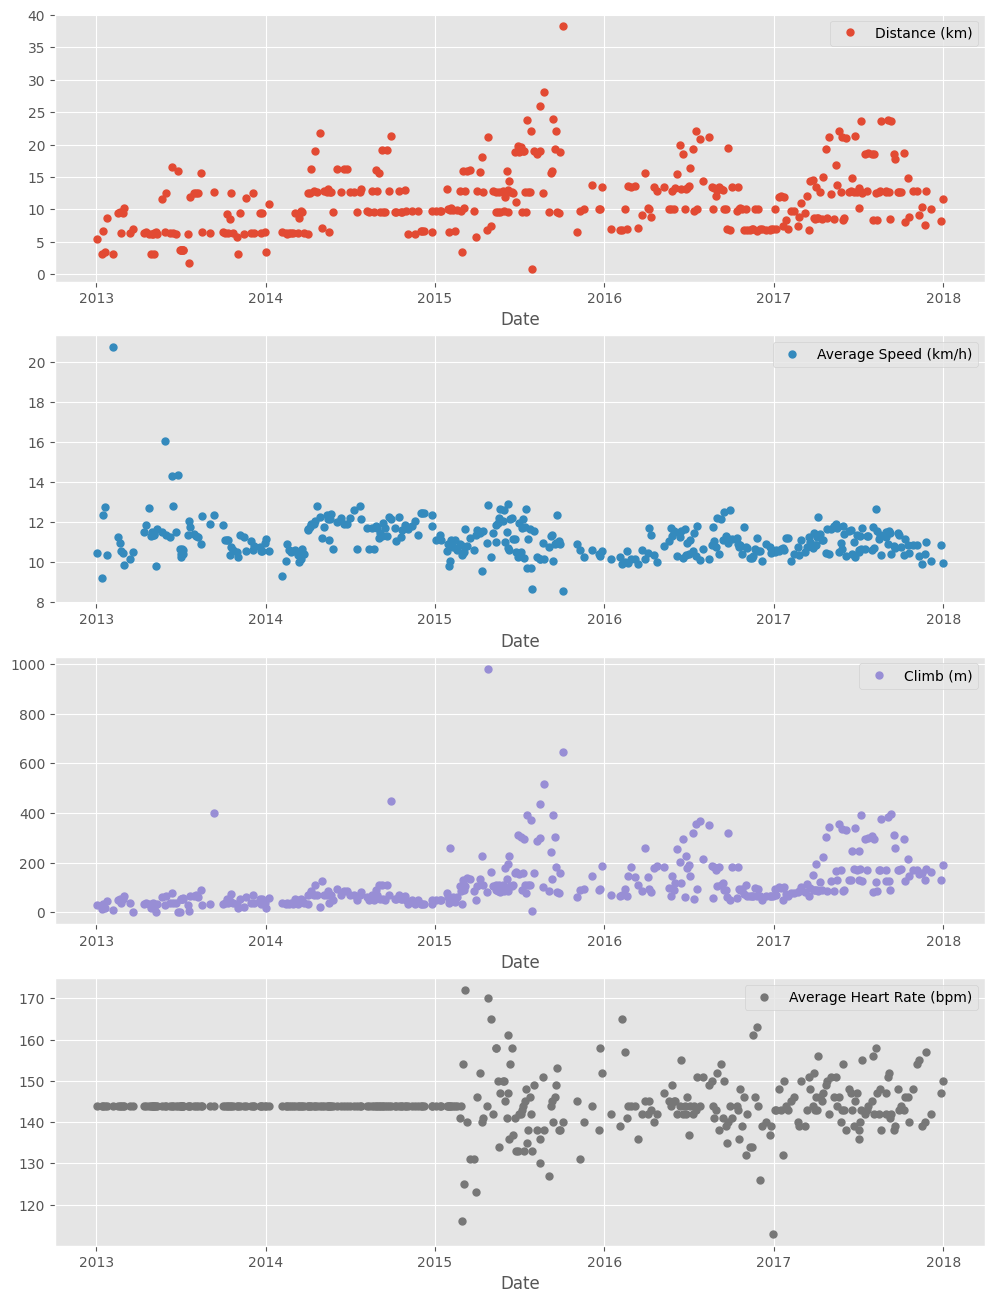

In [5]:
          # Task 4: Plot running data

          %matplotlib inline

          # Import matplotlib, set style and ignore warning
          import matplotlib.pyplot as plt
          %matplotlib inline
          import warnings
          plt.style.use('ggplot')
          warnings.filterwarnings(
              action='ignore', module='matplotlib.figure', category=UserWarning,
              message=('This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.')
          )

          # Prepare data subsetting period from 2013 till 2018
          runs_subset_2013_2018 = df_run.loc[(df_run.index >= '2013') & (df_run.index <= '2018')]


          # Create, plot and customize in one step
          runs_subset_2013_2018.plot(subplots=True,
                                    sharex=False,
                                    figsize=(12,16),
                                    linestyle='none',
                                    marker='o',
                                    markersize=5,
                                    )

          # Show plot
          plt.show()

**Task 5: Running Statistics**

Running is a great way to stay healthy and happy, both in your mind and body, no matter how old you are. Plus, it's really fun! When runners talk to each other about running, they don't just talk about their results. They also talk about different ways to train.

You can tell you're around runners if you hear them asking each other questions like:

•	How far do you usually run?

•	How quickly do you run?

•	Do you keep track of your heart rate?

•	How often do you train?

Let's use my data to answer these questions. If you look back at the graphs in Task 4, you can see that I didn't measure my heart rate before 2015. So, let's just use the data from 2015 to 2018 to look at the averages.

 In pandas, there's a method called resample() that works like the groupby() method. It lets you group time series data by a specific time period. We'll use resample() to group the data by year and by week and apply different methods to each group.

In [6]:
          # Task 5: Running statistics

          runs_subset_2015_2018 = df_run[(df_run.index <= '2018') & (df_run.index>='2015')]
          runs_subset_2015_2018.head()

,Type,Distance (km),Duration,Average Pace,Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,,,,
2017-12-30 17:11:53,Running,11.69,1:10:16,6:01,9.98,192,150.0
2017-12-27 18:50:24,Running,8.29,45:56,5:33,10.83,131,147.0
2017-12-04 18:14:41,Running,10.00,59:43,5:58,10.05,160,142.0
2017-11-25 12:17:22,Running,12.85,1:10:04,5:27,11.00,176,157.0
2017-11-22 18:21:12,Running,7.55,43:29,5:46,10.42,129,140.0


In [10]:
          # Task 5: Running statistics

          # Prepare running data for the last 4 years
          runs_subset_2015_2018 = df_run.loc[(df_run.index >= '2015') & (df_run.index <= '2018')]

          # Calculate annual statistics
          print('The Average run looks in last 4 years:')
          # display(runs_subset_2015_2018.resample('A').mean())
          display(runs_subset_2015_2018.resample('A').mean(numeric_only=True))

          # Calculate weekly statistics
          print('Weekly average of last 4 years:')
          # display(runs_subset_2015_2018.resample('W').mean().mean())
          display(runs_subset_2015_2018.resample('W').mean(numeric_only=True).mean())


          # Mean weekly counts
          weekly_counts_average = runs_subset_2015_2018['Distance (km)'].resample('W').count().mean()
          print('How many trainings per week I had on average:', weekly_counts_average)

The Average run looks in last 4 years:


,Distance (km),Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,
2015-12-31,13.602805,10.998902,160.170732,143.353659
2016-12-31,11.411667,10.837778,133.194444,143.388889
2017-12-31,12.935176,10.959059,169.376471,145.247059


Weekly average of last 4 years:


Distance (km)                12.429010
Average Speed (km/h)         10.875890
Climb (m)                   151.162907
Average Heart Rate (bpm)    143.991228
dtype: float64

How many trainings per week I had on average: 1.5222929936305734


**Task 6: Visualization with averages**

Let's make a graph that shows the average distance I ran and my average heart rate over time, along with the actual data from each training session. This way, we can see how the averages compare to each session. We'll use the data from 2015 to 2018.

In this task, we'll use the tools in matplotlib to make and customize our graph.

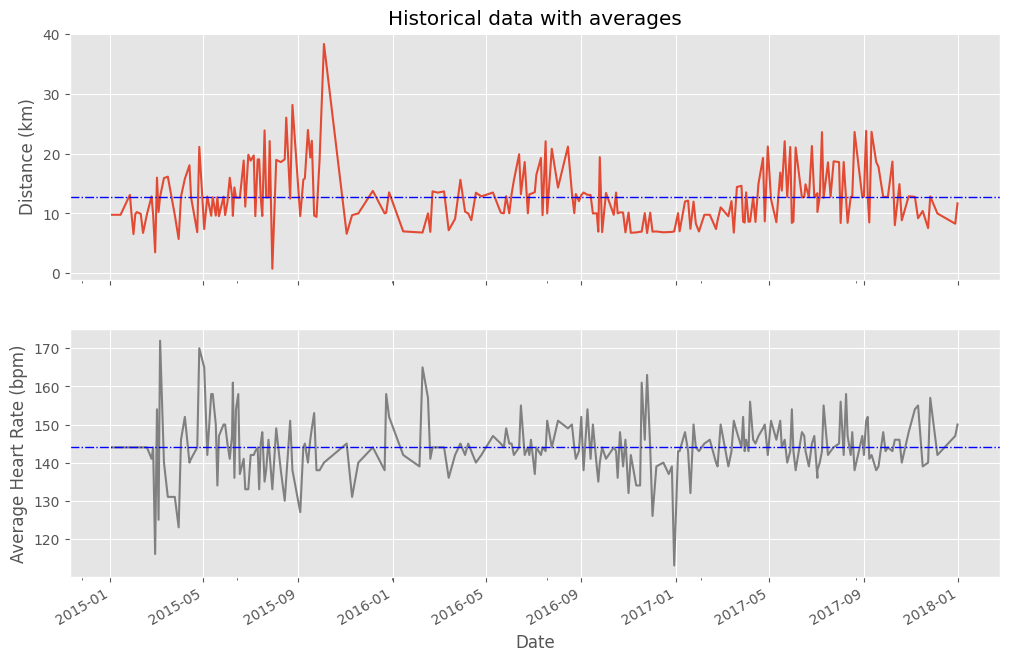

In [11]:
          # Task 6: Visualization with averages

          # Prepare data
          runs_subset_2015_2018 = df_run.loc[(df_run.index >= '2015') & (df_run.index <= '2018')]
          runs_distance = runs_subset_2015_2018['Distance (km)']
          runs_hr = runs_subset_2015_2018['Average Heart Rate (bpm)']

          # Create plot
          fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

          # Plot and customize first subplot
          runs_distance.plot(ax=ax1)
          ax1.set(ylabel='Distance (km)', title='Historical data with averages')
          ax1.axhline(runs_distance.mean(), color='blue', linewidth=1, linestyle='-.')


          # Plot and customize second subplot
          runs_hr.plot(ax=ax2, color='gray')
          ax2.set(xlabel='Date', ylabel='Average Heart Rate (bpm)')
          # ... YOUR CODE FOR TASK 6 ...
          ax2.axhline(runs_hr.mean(), color='blue', linewidth=1, linestyle='-.')

          # Show plot
          plt.show()

**Task 7: Did I reach my goals?**

To keep myself motivated to run regularly, I set a goal to run 1000 km every year. Let's make a graph that shows how far I ran each year from 2013 to 2018 to see if I met my goal. If the stars on the graph are in the green area, that means I reached my goal.

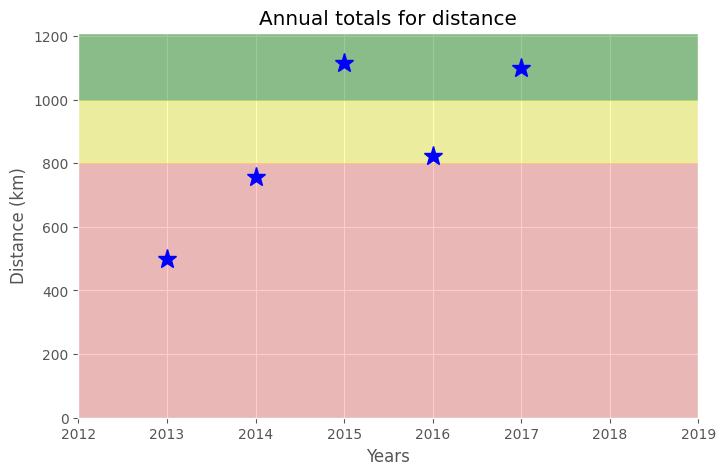

In [12]:
            # Task 7: Did I reach my goals?
            # Prepare data
            df_run_dist_annual = df_run.loc[(df_run.index >= '2013') & (df_run.index <= '2018'), 'Distance (km)'].resample('A').sum()

            # Create plot
            fig = plt.figure(figsize=(8, 5))

            # Plot and customize
            ax = df_run_dist_annual.plot(marker='*', markersize=14, linewidth=0, color='blue')
            ax.set(ylim=[0, 1210], 
                  xlim=['2012','2019'],
                  ylabel='Distance (km)',
                  xlabel='Years',
                  title='Annual totals for distance')

            ax.axhspan(1000, 1210, color='green', alpha=0.4)
            ax.axhspan(800, 1000, color='yellow', alpha=0.3)
            # ... YOUR CODE FOR TASK 7 ...
            ax.axhspan(0, 800, color = 'red', alpha=0.2)

            # Show plot
plt.show()

**Task 8: Am I progressing?**

Let's take a closer look at the data to see if I'm getting better at running. 

We'll do this by breaking down how far I ran each week and comparing it to the actual data. A red line on the graph will show the weekly distance I ran. 

We'll use a tool called statsmodels to break down the weekly trend.

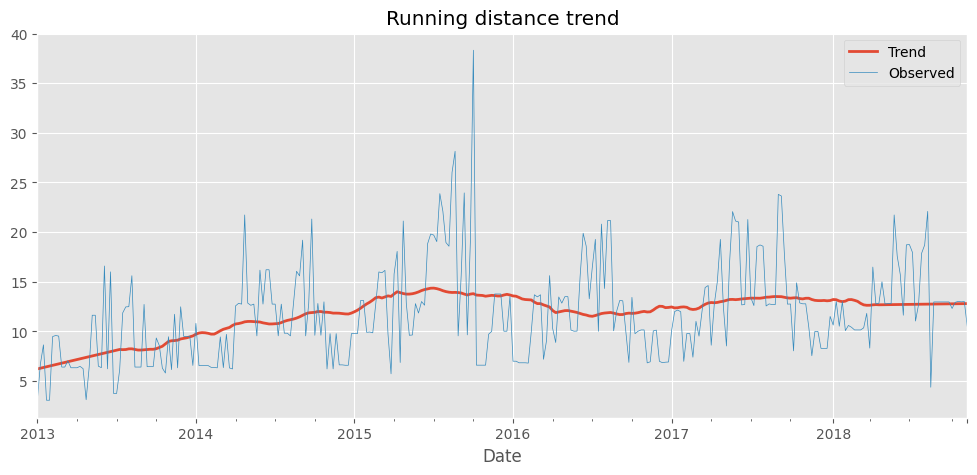

In [22]:
          # Task 8: Am I progressing?
          # Import required library
          import statsmodels.api as sm

          # Prepare data
          #df_run_dist_wkly = df_run['2018':'2013']['Distance (km)'].resample('W').bfill()
          # df_run_dist_wkly = df_run.loc['2013':'2018', 'Distance (km)'].resample('W').bfill()
          df_run_dist_wkly = df_run.sort_index().loc['2013':'2018', 'Distance (km)'].resample('W').bfill()

          decomposed = sm.tsa.seasonal_decompose(df_run_dist_wkly, extrapolate_trend=1)

          # Create plot
          fig = plt.figure(figsize=(12, 5))

          # Plot and customize
          ax = decomposed.trend.plot(label='Trend', linewidth=2)
          ax = decomposed.observed.plot(label='Observed', linewidth=0.5)

          ax.legend()
          ax.set_title('Running distance trend')

          # Show plot
          plt.show()

**Task 9: Training Intensity**

Heart rate is often used to measure how hard someone is training. Depending on how old and fit someone is, their heart rate can be put into different zones based on their training goals. For example, during moderate exercise, the goal is to have a heart rate that is 50-70% of the highest it can go. During intense exercise, the goal is 70-85% of the highest it can go.

 We'll make a graph that shows how my heart rate data is spread out based on how hard I was training. The graph will show how many activities I did in each training zone.

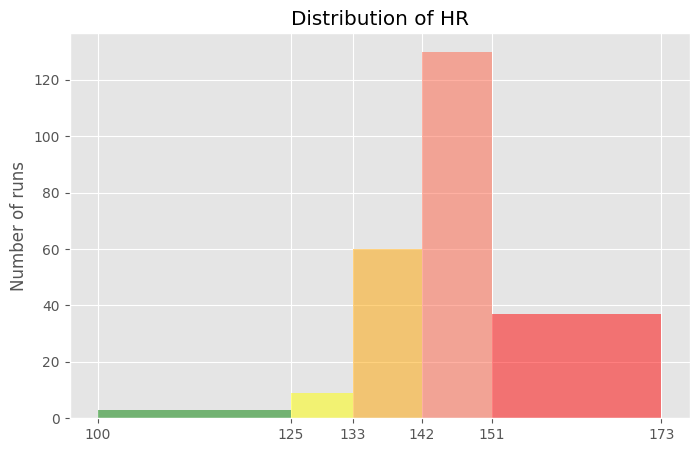

In [16]:
          # Task 9: Training intensity
          # Prepare data
          hr_zones = [100, 125, 133, 142, 151, 173]
          zone_names = ['Easy', 'Moderate', 'Hard', 'Very hard', 'Maximal']
          zone_colors = ['green', 'yellow', 'orange', 'tomato', 'red']
          df_run_hr_all = df_run.loc[(df_run.index<='2018') & (df_run.index >= '2015'), 'Average Heart Rate (bpm)']

          # Create plot
          fig, ax = plt.subplots(figsize=(8, 5))

          # Plot and customize
          n, bins, patches = ax.hist(df_run_hr_all, bins=hr_zones, alpha=0.5)
          for i in range(0, len(patches)):
              patches[i].set_facecolor(zone_colors[i])
            
              ax.set(title='Distribution of HR', ylabel='Number of runs')
              ax.xaxis.set(ticks=hr_zones)
              #ax.set_xticklabels(labels=zone_names, rotation=-30, ha='left')


          # Show plot
          plt.show()

**Task 10: Detailed summary report**

After cleaning, analyzing, and visualizing all this data, let's make some tables that summarize my training. 

We'll make two tables. The first one will show the total distance I ran and how much I climbed for each type of training. The second one will show the average speed, climb, and distance for each type of training.

In [17]:
          # Task 10 : Detailed summary report

          # Concatenating three DataFrames
          df_run_walk_cycle = pd.concat([df_run,df_walk,df_cycle] , axis=0)
          dist_climb_cols, speed_col = ['Distance (km)', 'Climb (m)'], ['Average Speed (km/h)']

          #display(df_run_walk_cycle)

          # Calculating total distance and climb in each type of activities
          df_totals = df_run_walk_cycle.groupby('Type')[dist_climb_cols].sum()

          print('Totals for different training types:')
          display(df_totals)

          # Calculating summary statistics for each type of activities 
          df_summary = df_run_walk_cycle.groupby('Type')[dist_climb_cols + speed_col].describe()

          # Combine totals with summary
          for i in dist_climb_cols:
              df_summary[i, 'total'] = df_totals[i]

          print('Summary statistics for different training types:')
          df_summary.stack()

Totals for different training types:


,Distance (km),Climb (m)
Type,,
Cycling,680.58,6976
Running,5224.50,57278
Walking,33.45,349


Summary statistics for different training types:


Average Speed (km/h)     Climb (m)  Distance (km)
Type                                                            
Cycling 25%               16.980000    139.000000      15.530000
        50%               19.500000    199.000000      20.300000
        75%               21.490000    318.000000      29.400000
        count             29.000000     29.000000      29.000000
        max               24.330000    553.000000      49.180000
        mean              19.125172    240.551724      23.468276
        min               11.380000     58.000000      11.410000
        std                3.257100    128.960289       9.451040
        total                   NaN   6976.000000     680.580000
Running 25%               10.495000     54.000000       7.415000
        50%               10.980000     91.000000      10.810000
        75%               11.520000    171.000000      13.190000
        count            459.000000    459.000000     459.000000
        max               20.720000    982.000000      38.320000
        mean              11.056296    124.788671      11.382353
        min                5.770000      0.000000       0.760000
        std                0.953273    103.382177       4.937853
        total                   NaN  57278.000000    5224.500000
Walking 25%                5.555000      7.000000       1.385000
        50%                5.970000     10.000000       1.485000
        75%                6.512500     15.500000       1.787500
        count             18.000000     18.000000      18.000000
        max                6.910000    112.000000       4.290000
        mean               5.549444     19.388889       1.858333
        min                1.040000      5.000000       1.220000
        std                1.459309     27.110100       0.880055
        total                   NaN    349.000000      33.450000

**Task 11: FunFacts**

To finish up, let's look at some fun facts from the summary tables and do one last exercise. My running history covers 6 years, 2 months, and 21 days. I remember that I went through 7 pairs of running shoes during that time.

FUN FACTS
- Average distance: 11.38 km
- Longest distance: 38.32 km
- Highest climb: 982 m
- Total climb: 57,278 m
- Total distance run: 5,224 km
- Total runs: 459
- Number of running shoes used: 7 pairs

You might know the story of Forrest Gump. He decided to go for a "little run" that ended up lasting for 3 years, 2 months, and 14 days (1169 days). In the picture, you can see that he ran a total of 24,700 km.

FORREST RUN FACTS
- Average distance: 21.13 km
- Total distance run: 24,700 km
- Total runs: 1169
- Number of running shoes used: ...

If Forrest and I go through running shoes at the same rate, can you figure out how many pairs of shoes he needed for his run?

In [18]:
          #Task 11: FunFacts
          # Count average shoes per lifetime (as km per pair) using our fun facts
          average_shoes_lifetime = 5224 / 7

          # Count number of shoes for Forrest's run distance
          shoes_for_forrest_run = int(24700 / average_shoes_lifetime)

          print('Forrest Gump would need {} pairs of shoes!'.format(shoes_for_forrest_run))

Forrest Gump would need 33 pairs of shoes!
